# Training 

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras_core
import matplotlib.pyplot as plt

Using PyTorch backend.


Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.
Using 656 files for training.
Using 655 files for validation.
Number of training samples: 179
Number of validation samples: 21
Number of testing samples: 21


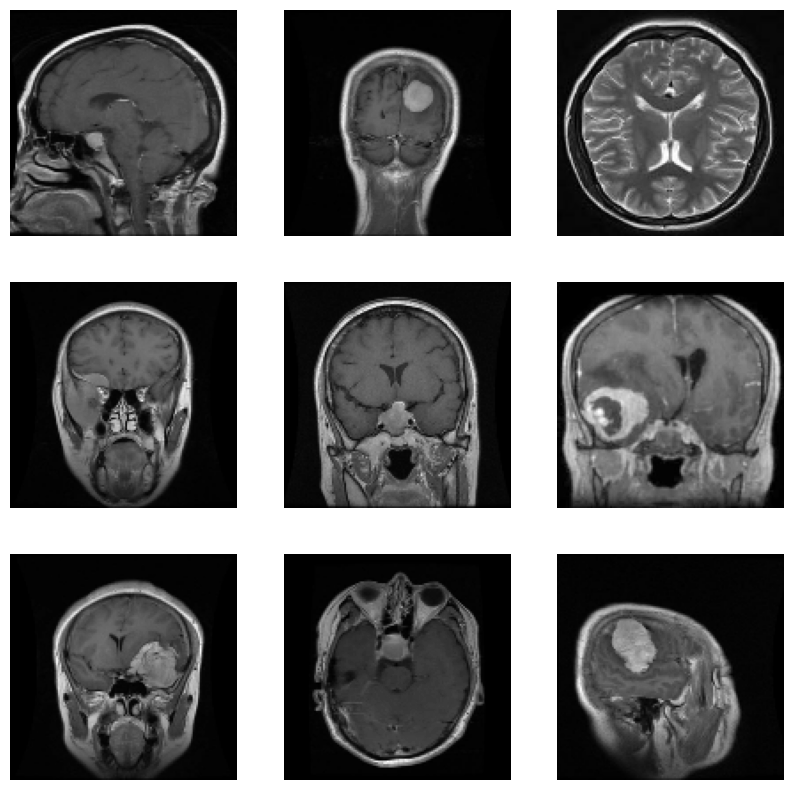

In [8]:
train_ds = keras_core.utils.image_dataset_from_directory(
    directory='dataset/training_data',
    labels='inferred',
    color_mode='grayscale',
    label_mode='categorical',
    batch_size=32,
    image_size=(128, 128))


validation_ds, testing_ds = keras_core.utils.image_dataset_from_directory(
    directory='dataset/validation_data',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    validation_split=0.5,
    subset='both',
    seed=2,
    batch_size=32,
    image_size=(128, 128))


print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f"Number of testing samples: {testing_ds.cardinality()}")

# Take the first 9 images from the training dataset
images = train_ds.take(1)

# Display the images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()

for i, image in enumerate(images):
    for x in range(9):
        axes[x].imshow(image[0][x].numpy().astype("uint8"), cmap='gray')
        axes[x].axis('off')
    
plt.show()

In [9]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
testing_ds = testing_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [10]:
data_augmentation = keras_core.Sequential(
    [
        keras_core.layers.RandomFlip(),
    ]
)

base_model = keras_core.applications.MobileNetV3Small(
    weights=None,  # Load weights pre-trained on ImageNet.
    input_shape=(128, 128, 1),
    include_top=False, 
    include_preprocessing=False)  # Do not include the ImageNet classifier at the top.


# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras_core.Input(shape=(128, 128, 1))
x = data_augmentation(inputs)  # Apply random data augmentation

# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras_core.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras_core.layers.GlobalAveragePooling2D()(x)
x = keras_core.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras_core.layers.Dense(4, activation="softmax")(x)
model = keras_core.Model(inputs, outputs)

model.summary()



Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 128, 128, 1)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ sequential_3 (Sequential)       │ (None, 128, 128, 1)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ rescaling_2 (Rescaling)         │ (None, 128, 128, 1)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ MobilenetV3small (Functional)   │ (None, 4, 4, 576)         │    938,832 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling2d_2      │ (None, 576)               │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_2 (Dropout)             │ (None, 576)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 4)                 │      2,308 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 941,140 (3.59 MB)

 Trainable params: 2,308 (9.02 KB)

 Non-trainable params: 938,832 (3.58 MB)

In [11]:
early_stop = keras_core.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True, mode="min"
    )


model.compile(
    optimizer=keras_core.optimizers.Adamax(),
    loss=keras_core.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras_core.metrics.SparseCategoricalAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

2023-10-07 01:55:22.155189: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


RuntimeError: Unable to automatically build the model. Please build it yourself before calling fit/evaluate/predict. A model is 'built' when its variables have been created and its `self.built` attribute is True. Usually, calling the model on a batch of data is the right way to build it.